In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import Recall, Precision
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from google.colab import drive
import warnings
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [41]:
IMG_SIZE = 224
BATCH_SIZE = 64



train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/stroke_classification/Train',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/stroke_classification/Train',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/stroke_classification/Test',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2376 files belonging to 2 classes.
Using 1901 files for training.
Found 2376 files belonging to 2 classes.
Using 475 files for validation.
Found 250 files belonging to 2 classes.


In [3]:
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true[0]

0

In [4]:
IMG_IND=224
IMG_SHAPE = (IMG_IND,IMG_IND,3) # transfer learning accept only 3 channel
LOSS = BinaryCrossentropy()
SEED = 7

In [5]:
def callbacks(model_name):
  CallBacks = []

  best_model = ModelCheckpoint(filepath=f'{model_name}.keras',monitor='val_loss',verbose=1,save_best_only=True)
  CallBacks.append(best_model)

  early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1)
  CallBacks.append(early_stop)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=0.00001)
  CallBacks.append(reduce_lr)

  return CallBacks

#DenseNet121

In [6]:
optimizer = Adam(learning_rate=0.001)

base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
)


for layer in base_model.layers[421:]:
  layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

denseNet_model = tf.keras.Model(inputs=base_model.input, outputs=x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
denseNet_model.compile(
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy',Recall(),Precision()]
)

In [8]:
len(denseNet_model.layers)

430

In [9]:
call_backs = callbacks('DenseNet121')
denseNet_model.fit(train_data,epochs=10,validation_data=validation_data,callbacks=call_backs)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6344 - loss: 0.7703 - precision: 0.5483 - recall: 0.5341 
Epoch 1: val_loss improved from inf to 17.00776, saving model to DenseNet121.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 712s 18s/step - accuracy: 0.6369 - loss: 0.7651 - precision: 0.5515 - recall: 0.5356 - val_accuracy: 0.4274 - val_loss: 17.0078 - val_precision: 0.4274 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8345 - loss: 0.3762 - precision: 0.7959 - recall: 0.7881
Epoch 2: val_loss improved from 17.00776 to 2.87454, saving model to DenseNet121.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.8354 - loss: 0.3747 - precision: 0.7971 - recall: 0.7891 - val_accuracy: 0.5874 - val_loss: 2.8745 - val_precision: 0.5113 - val_recall: 0.7833 - learning_rate: 0.0010
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9262 - loss: 0.1867 - precision: 0.9254 - recall: 0.8842
Epoch 3: val_l

In [10]:
best_denseNet = tf.keras.models.load_model('DenseNet121.keras')
best_denseNet.evaluate(test_data,verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.9090 - loss: 0.4712 - precision: 0.5284 - recall: 0.7840


[0.48897889256477356,
 0.9039999842643738,
 0.9599999785423279,
 0.8633093237876892]

In [11]:
y_pred = best_denseNet.predict(test_data)
y_pred = np.round(y_pred)
print(classification_report(y_true,y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       125
           1       0.86      0.96      0.91       125

    accuracy                           0.90       250
   macro avg       0.91      0.90      0.90       250
weighted avg       0.91      0.90      0.90       250



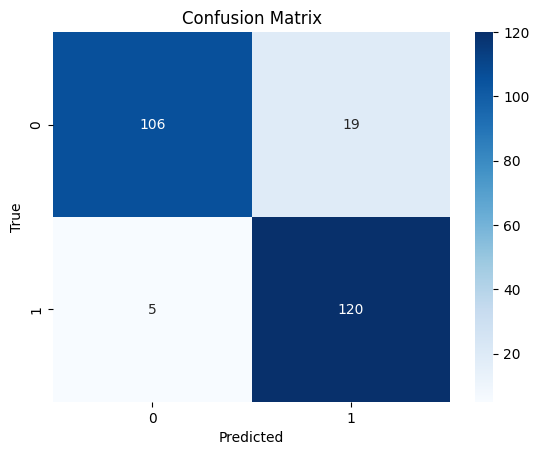

In [12]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## RESNet 50

In [13]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
)

for layer in base_model.layers[420:]:
  layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

RESNet_model = tf.keras.Model(inputs=base_model.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
optimizer = Adam(learning_rate=0.001)

RESNet_model.compile(
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy',Recall(),Precision()]
)

In [15]:
call_backs = callbacks('ResNet50')
RESNet_model.fit(train_data,epochs=15,validation_data=validation_data,callbacks=call_backs)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6292 - loss: 0.7871 - precision_1: 0.5058 - recall_1: 0.4802   
Epoch 1: val_loss improved from inf to 319.71033, saving model to ResNet50.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6319 - loss: 0.7820 - precision_1: 0.5101 - recall_1: 0.4849 - val_accuracy: 0.4274 - val_loss: 319.7103 - val_precision_1: 0.4274 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8424 - loss: 0.3742 - precision_1: 0.8250 - recall_1: 0.7716
Epoch 2: val_loss improved from 319.71033 to 3.63175, saving model to ResNet50.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 58s 827ms/step - accuracy: 0.8438 - loss: 0.3713 - precision_1: 0.8264 - recall_1: 0.7737 - val_accuracy: 0.8021 - val_loss: 3.6317 - val_precision_1: 0.7422 - val_recall_1: 0.8227 - learning_rate: 0.0010
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9385 - loss: 0.1505 - precision_1: 0.9301 - recall

In [16]:
best_RESNet = tf.keras.models.load_model('ResNet50.keras')
best_RESNet.evaluate(test_data,verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9648 - loss: 0.1765 - precision_1: 0.6090 - recall_1: 0.7968


[0.18447524309158325,
 0.9639999866485596,
 0.9919999837875366,
 0.939393937587738]

In [17]:
y_pred = best_RESNet.predict(test_data)
y_pred = np.round(y_pred)
print(classification_report(y_true,y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       125
           1       0.94      0.99      0.96       125

    accuracy                           0.96       250
   macro avg       0.97      0.96      0.96       250
weighted avg       0.97      0.96      0.96       250



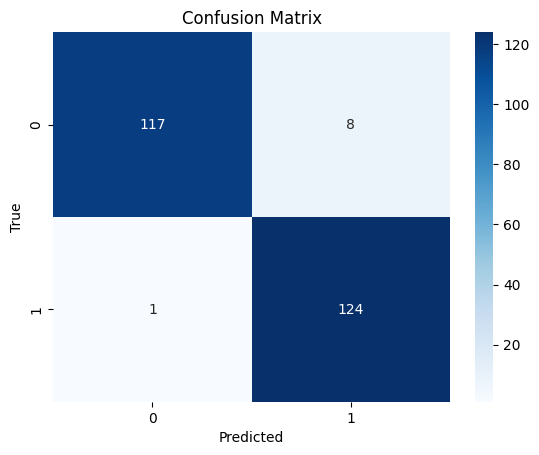

In [18]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##MobileNet model

In [19]:
base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
)

for layer in base_model.layers[420:]:
  layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

MobileNet_model = tf.keras.Model(inputs=base_model.input, outputs=x)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
optimizer = Adam(learning_rate=0.001)

MobileNet_model.compile(
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy',Recall(),Precision()]
)

In [21]:
call_backs = callbacks('MobileNet')
MobileNet_model.fit(train_data,epochs=15,validation_data=validation_data,callbacks=call_backs)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.6500 - loss: 0.8609 - precision_2: 0.5591 - recall_2: 0.5508
Epoch 1: val_loss improved from inf to 3.32730, saving model to MobileNet.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6527 - loss: 0.8533 - precision_2: 0.5624 - recall_2: 0.5540 - val_accuracy: 0.5726 - val_loss: 3.3273 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8927 - loss: 0.2564 - precision_2: 0.8780 - recall_2: 0.8517
Epoch 2: val_loss improved from 3.32730 to 2.95239, saving model to MobileNet.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.8934 - loss: 0.2547 - precision_2: 0.8786 - recall_2: 0.8527 - val_accuracy: 0.5726 - val_loss: 2.9524 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9734 - loss: 0.0830 - precision_2: 0.97

In [22]:
best_MobileNet = tf.keras.models.load_model('MobileNet.keras')
best_MobileNet.evaluate(test_data,verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9690 - loss: 0.1593 - precision_2: 0.6197 - recall_2: 0.7968


[0.15379267930984497,
 0.9679999947547913,
 0.9919999837875366,
 0.9465649127960205]

In [23]:
y_pred = best_MobileNet.predict(test_data)
y_pred = np.round(y_pred)
print(classification_report(y_true,y_pred))

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 690ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       125
           1       0.95      0.99      0.97       125

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



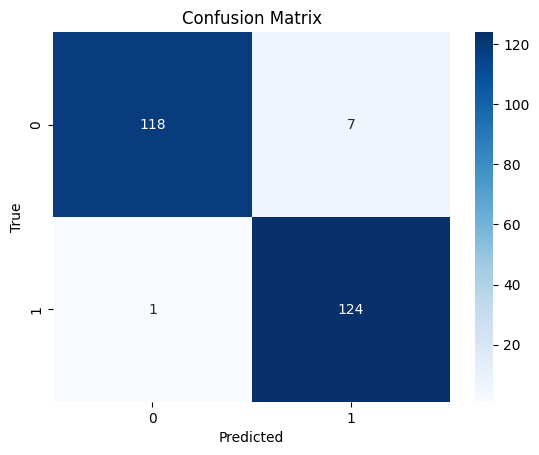

In [24]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Xception

In [25]:
base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
)

for layer in base_model.layers[420:]:
  layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

Xception_model = tf.keras.Model(inputs=base_model.input, outputs=x)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
optimizer = Adam(learning_rate=0.001)

Xception_model.compile(
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy',Recall(),Precision()]
)

In [27]:
call_backs = callbacks('xception')
Xception_model.fit(train_data,epochs=15,validation_data=validation_data,callbacks=call_backs)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6643 - loss: 0.5965 - precision_3: 0.5898 - recall_3: 0.4488   
Epoch 1: val_loss improved from inf to 0.89747, saving model to xception.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.6669 - loss: 0.5938 - precision_3: 0.5935 - recall_3: 0.4536 - val_accuracy: 0.7137 - val_loss: 0.8975 - val_precision_3: 0.7965 - val_recall_3: 0.4433 - learning_rate: 0.0010
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.8916 - loss: 0.2383 - precision_3: 0.8619 - recall_3: 0.8562
Epoch 2: val_loss improved from 0.89747 to 0.81050, saving model to xception.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8927 - loss: 0.2362 - precision_3: 0.8633 - recall_3: 0.8577 - val_accuracy: 0.8421 - val_loss: 0.8105 - val_precision_3: 0.8556 - val_recall_3: 0.7586 - learning_rate: 0.0010
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9663 - loss: 0.0896 - precision_3: 0.9567 - recall_3: 0.956

In [28]:
best_Xception = tf.keras.models.load_model('xception.keras')
best_Xception.evaluate(test_data,verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.9774 - loss: 0.0797 - precision_3: 0.6456 - recall_3: 0.7968


[0.0969008207321167, 0.9760000109672546, 0.9919999837875366, 0.961240291595459]

In [29]:
y_pred = best_Xception.predict(test_data)
y_pred = np.round(y_pred)
print(classification_report(y_true,y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 944ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       125
           1       0.96      0.99      0.98       125

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



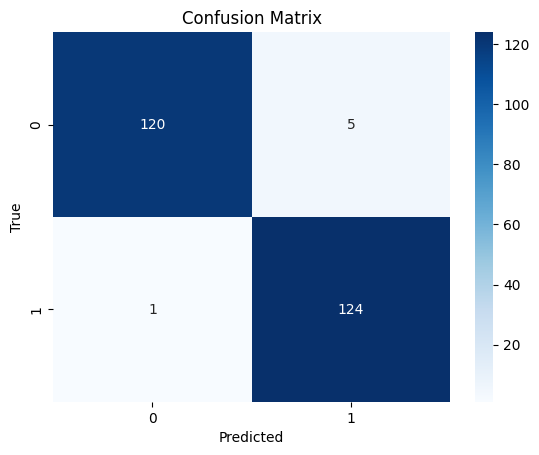

In [30]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()